In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

## 데이터 불러오기

In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week02/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'
column_names = ['user_id', 'activity', 'timestamp', 'x_accel', 'y_accel', 'z_accel']
df = pd.read_csv(file_path, sep=',', header=None, names=column_names, on_bad_lines='skip')
df['z_accel'] = df['z_accel'].str.rstrip(';')
df['z_accel'] = pd.to_numeric(df['z_accel'])

In [5]:
print(df.head())

   user_id activity       timestamp   x_accel    y_accel   z_accel
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164


## 데이터 전처리

In [6]:
df.shape

(1086466, 6)

In [7]:
df.describe()

,user_id,timestamp,x_accel,y_accel,z_accel
count,1.086466e+06,1.086466e+06,1.086466e+06,1.086466e+06,1.086465e+06
mean,1.883755e+01,3.250277e+13,6.641165e-01,7.246042e+00,3.976974e-01
std,1.026681e+01,4.893649e+13,6.876275e+00,6.739787e+00,4.761111e+00
min,1.000000e+00,0.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,1.999712e+12,-2.910000e+00,3.170000e+00,-2.220117e+00
50%,1.900000e+01,9.396193e+12,2.700000e-01,7.930000e+00,0.000000e+00
75%,2.800000e+01,3.509472e+13,4.440000e+00,1.156000e+01,2.720000e+00
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


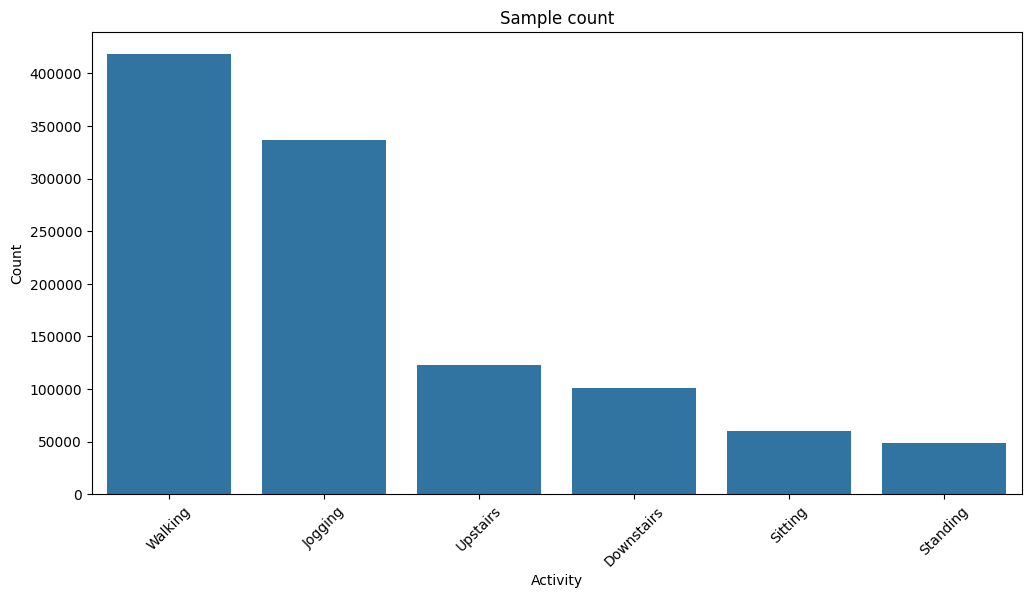

In [8]:
plt.figure(figsize=(12, 6))

sns.countplot(x='activity', data=df, order=df['activity'].value_counts().index)

plt.title('Sample count')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [9]:
print(df.isnull().sum())

user_id      0
activity     0
timestamp    0
x_accel      0
y_accel      0
z_accel      1
dtype: int64


In [10]:
df = df.dropna()

In [11]:
label_encoder = LabelEncoder()
df['activity_encoded'] = label_encoder.fit_transform(df['activity'])

In [12]:
for i, class_name in enumerate(label_encoder.classes_):
    print(f"'{class_name}'  ->  {i}")

'Downstairs'  ->  0
'Jogging'  ->  1
'Sitting'  ->  2
'Standing'  ->  3
'Upstairs'  ->  4
'Walking'  ->  5


In [13]:
X = df.drop(columns=["activity", "user_id", "timestamp", "activity_encoded"])
y = df["activity_encoded"]

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
scaled_features_df = pd.DataFrame(X_scaled, columns=X.columns)

In [16]:
print(scaled_features_df.head())

    x_accel   y_accel   z_accel
0 -0.197600  0.806331  0.022317
1  0.632345  0.596159  0.116722
2  0.616498  0.539574 -0.100695
3 -0.185715  1.669250  0.551556
4 -0.268908  0.721454  1.429807


In [17]:
num_classes = len(label_encoder.classes_)

## 시계열 데이터 분할

In [18]:
TIME_STEPS = 80
STEP = 40

def create_segments(features, labels, time_steps, step):
    segments = []
    segment_labels = []

    for i in range(0, len(features) - time_steps + 1, step):
        # features에서 time_steps 길이만큼의 데이터를 추출
        segment = features.iloc[i: i + time_steps].values

        # 해당 윈도우에서 가장 빈번하게 나타난 활동을 레이블로 지정 (mode)
        # stats.mode()는 최빈값과 그 횟수를 반환하므로 [0]으로 값만 추출
        label = stats.mode(labels.iloc[i: i + time_steps])[0]

        segments.append(segment)
        segment_labels.append(label)

    return np.array(segments), np.array(segment_labels)

In [19]:
X_segmented, y_segmented = create_segments(
    scaled_features_df,
    y,
    TIME_STEPS,
    STEP
)

In [20]:
print("X_segmented shape:", X_segmented.shape)
print("y_segmented shape:", y_segmented.shape)

X_segmented shape: (27160, 80, 3)
y_segmented shape: (27160,)


In [21]:
y_one_hot = to_categorical(y_segmented, num_classes=num_classes)

In [22]:
print("y_one_hot shape:", y_one_hot.shape)

y_one_hot shape: (27160, 6)


## 데이터 분리 및 모델 학습

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_segmented,
    y_one_hot,
    test_size=0.2,
    random_state=42,
    stratify=y_one_hot
)

In [24]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (21728, 80, 3)
y_train shape: (21728, 6)
X_test shape: (5432, 80, 3)
y_test shape: (5432, 6)


In [25]:
input_shape = (X_train.shape[1], X_train.shape[2])

In [26]:
model = Sequential([
    # 입력층
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Dropout(0.5),
    MaxPooling1D(pool_size=2),

    # 중간층
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Dropout(0.5),
    GlobalAveragePooling1D(),

    # 완전 연결층
    Dense(128, activation='relu'),
    Dropout(0.5),

    # 출력층
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 78, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 76, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 76, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 36, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 34, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,262 (407.27 KB)

 Trainable params: 104,262 (407.27 KB)

 Non-trainable params: 0 (0.00 B)

## 모델 컴파일 및 학습

In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6114 - loss: 0.9798 - val_accuracy: 0.8557 - val_loss: 0.3822
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8633 - loss: 0.3836 - val_accuracy: 0.9045 - val_loss: 0.2525
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9028 - loss: 0.2734 - val_accuracy: 0.9284 - val_loss: 0.2025
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9269 - loss: 0.2124 - val_accuracy: 0.9505 - val_loss: 0.1579
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9371 - loss: 0.1852 - val_accuracy: 0.9554 - val_loss: 0.1370
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9474 - loss: 0.1627 - val_accuracy: 0.9554 - val_loss: 0.1191
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9551 - loss: 0.1352 - val_accuracy: 0.9669 - val_loss: 0.1005
Epoch 8/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9610 - loss: 0.1200 - val_accuracy:

## 평가

In [30]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

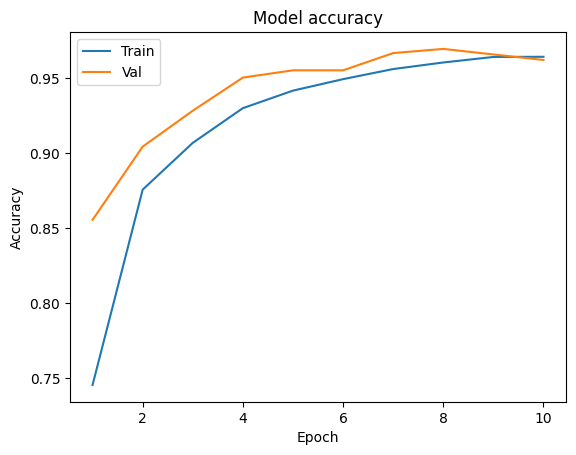

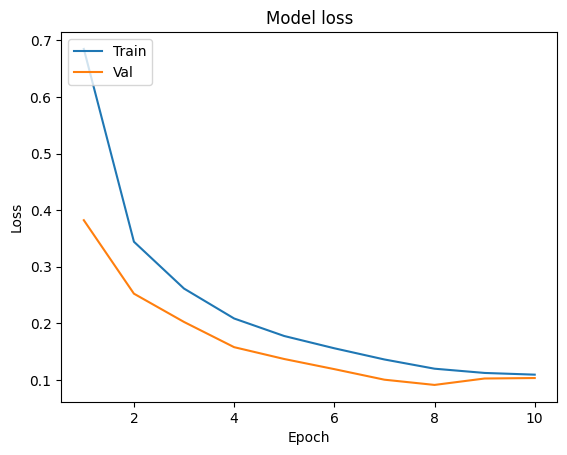

In [31]:
plot_learningCurve(history, 10)

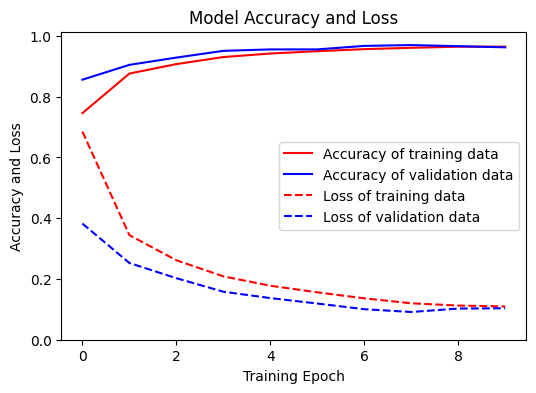

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], 'r', label = "Accuracy of training data")
plt.plot(history.history["val_accuracy"], 'b', label = "Accuracy of validation data")
plt.plot(history.history["loss"], 'r--', label = "Loss of training data")
plt.plot(history.history["val_loss"], 'b--', label = "Loss of validation data")
plt.title("Model Accuracy and Loss")
plt.ylabel("Accuracy and Loss")
plt.xlabel("Training Epoch")
plt.ylim(0)
plt.legend()
plt.show()

In [33]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


              precision    recall  f1-score   support

           0       0.77      0.96      0.86       503
           1       1.00      0.98      0.99      1682
           2       0.99      0.97      0.98       299
           3       0.98      1.00      0.99       242
           4       0.94      0.82      0.88       614
           5       0.99      0.98      0.99      2092

    accuracy                           0.96      5432
   macro avg       0.95      0.95      0.95      5432
weighted avg       0.97      0.96      0.96      5432



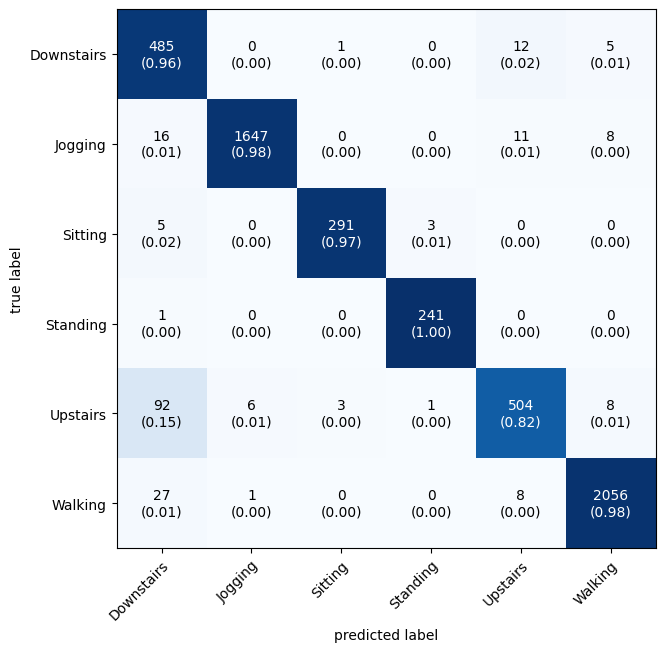

In [34]:
y_test_indices = y_test.argmax(axis=-1)

mat = confusion_matrix(y_test_indices, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label_encoder.classes_, show_normed=True, figsize=(7,7))

print(classification_report(y_test_indices, y_pred))